In [1]:
#1. bibliotheques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

## Sommaire
1. Import
2. Préparation des données
3. Baseline
4. Modèles linéaires
5. Modèles d’arbres
6. Méthodes d’ensemble
7. Choix du modèle
8. Analyse des features_importantes 
9. Analyse de la variable ENERGYSTARscore

In [2]:
print("\n2. CHARGEMENT et PREPARATION DES DONNÉES")
df_engineered = pd.read_csv("donnees_ameliorees.csv")
print(f"Shape des données : {df_engineered.shape}")
df_engineered.columns


2. CHARGEMENT et PREPARATION DES DONNÉES
Shape des données : (669, 23)


Index(['PropertyGFATotal', 'PropertyGFABuilding(s)', 'NumberofFloors',
       'NumberofBuildings', 'YearBuilt', 'PrimaryPropertyType',
       'LargestPropertyUseTypeGFA', 'ZipCode', 'Neighborhood', 'Latitude',
       'Longitude', 'ENERGYSTARScore', 'log_TotalGHGEmissions',
       'log_SiteEnergyUse_kBtu', 'BuildingAge', 'YearBuilt_bin',
       'AvgFloorArea', 'GFATotal_per_Building', 'PrimaryPropertyType_grouped',
       'Neighborhood_grouped', 'log_PropertyGFATotal',
       'log_LargestPropertyUseTypeGFA', 'log_AvgFloorArea'],
      dtype='object')

In [3]:
## DÉFINITION DES FEATURES ET DE LA CIBLE

target = 'log_SiteEnergyUse_kBtu'

# Listes de features qui serviront pour la prédiction 
numerical_features = [
    'log_PropertyGFATotal', 'log_LargestPropertyUseTypeGFA', 'log_AvgFloorArea',
    'BuildingAge', 'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'
]
categorical_features = ['PrimaryPropertyType_grouped', 'Neighborhood_grouped']

all_features = numerical_features + categorical_features

# On crée X et y
X = df_engineered[all_features]
y = df_engineered[target]

print("✓ Features et nouvelle cible sélectionnées.")

# DÉFINITION DU PREPROCESSEUR ET DIVISION STRATIFIÉE DES DONNÉES

#préprocesseur
preproc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])


#  On crée des catégories (strates) à partir de la cible continue
y_strat = pd.qcut(y, q=4, labels=False, duplicates='drop')

# On utilise ces strates dans le train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_strat # Ajout de la stratification
)

print(f"\n✓ Données prêtes pour l'entraînement (avec division stratifiée) :")
print(f"  - Taille de X_train : {X_train.shape}")
print(f"  - Taille de X_test : {X_test.shape}")

✓ Features et nouvelle cible sélectionnées.

✓ Données prêtes pour l'entraînement (avec division stratifiée) :
  - Taille de X_train : (535, 10)
  - Taille de X_test : (134, 10)


In [4]:

# Configuration de la validation croisée 
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# 1. Créer les catégories (strates) à partir de la variable cible 'y'
#    Cette étape est indispensable pour la stratification en régression.
y_strat = pd.qcut(y, q=4, labels=False, duplicates='drop')

# 2. Définir l'objet de validation croisée stratifiée à utiliser dans les GridSearchCV

cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Liste des métriques 
scoring = {
    'MAE':  'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error', 
    'R2':   'r2'
}

3. BASELINE

In [5]:
# mise en place du modèle de base DummyRegressor - prédit juste la moyenne
print(" MODÈLE BASELINE (DummyRegressor)")
print("-"*50)

dummy_pipe = Pipeline([
    ('prep', preproc),
    ('model', DummyRegressor(strategy='mean'))
])

# Cross-validation du baseline
cv_dummy = cross_validate(dummy_pipe, X_train, y_train, cv=cv, scoring=scoring)

baseline_r2 = cv_dummy['test_R2'].mean()
baseline_rmse = -cv_dummy['test_RMSE'].mean()
baseline_mae = -cv_dummy['test_MAE'].mean()

print(f"Baseline (DummyRegressor - moyenne) :")
print(f"  R2 CV    : {baseline_r2:.4f} ± {cv_dummy['test_R2'].std():.4f}")
print(f"  RMSE CV  : {baseline_rmse:.4f} ± {cv_dummy['test_RMSE'].std():.4f}")
print(f"  MAE CV   : {baseline_mae:.4f} ± {cv_dummy['test_MAE'].std():.4f}")
print(f" on note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base") 
print(f" pour le coefficent de détermination (R^2) l'objectif est d'avoir une valeur supérieure à - 0.0135, l'idéal étant un score positif")

 MODÈLE BASELINE (DummyRegressor)
--------------------------------------------------
Baseline (DummyRegressor - moyenne) :
  R2 CV    : -0.0135 ± 0.0075
  RMSE CV  : 1.2054 ± 0.1155
  MAE CV   : 0.9522 ± 0.1024
 on note ici que nos modèles à entrainer doivent avoir des résultats inférieurs au niveau des RMSE et MAE à ces moyennes de base
 pour le coefficent de détermination (R^2) l'objectif est d'avoir une valeur supérieure à - 0.0135, l'idéal étant un score positif


In [6]:
print("\n2. RÉGRESSION LINÉAIRE SIMPLE")
print("-" * 50)

# La régression linéaire sert de baseline pour comprendre
# les relations linéaires dans nos données avant d'ajouter de la régularisation
linear_pipe = Pipeline([('prep', preproc), ('model', LinearRegression())])
cv_linear  = cross_validate(
    linear_pipe,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True   # ← on récupère train_X et test_X
)
# très bon résultat et  point de départ, il explique 66 % de la variance, écart train/test limité (~0.04).
print(f"  R^2 train CV : {cv_linear ['train_R2'].mean():.4f} ± {cv_linear ['train_R2'].std():.4f}")
print(f"  R^2  test  CV : {cv_linear ['test_R2'].mean():.4f} ± {cv_linear ['test_R2'].std():.4f}")
print(f"  RMSE train CV : {-cv_linear ['train_RMSE'].mean():.4f} ± {cv_linear ['train_RMSE'].std():.4f}")
print(f"  RMSE test  CV : {-cv_linear ['test_RMSE'].mean():.4f} ± {cv_linear ['test_RMSE'].std():.4f}")
print(f"  MAE train CV  : {-cv_linear ['train_MAE'].mean():.4f} ± {cv_linear ['train_MAE'].std():.4f}")
print(f"  MAE test  CV  : {-cv_linear ['test_MAE'].mean():.4f} ± {cv_linear ['test_MAE'].std():.4f}")


2. RÉGRESSION LINÉAIRE SIMPLE
--------------------------------------------------
  R^2 train CV : 0.7135 ± 0.0114
  R^2  test  CV : 0.6604 ± 0.0321
  RMSE train CV : 0.6459 ± 0.0162
  RMSE test  CV : 0.6955 ± 0.0618
  MAE train CV  : 0.4858 ± 0.0116
  MAE test  CV  : 0.5290 ± 0.0429


3. MODELES LINEAIRES

In [7]:

print("3. MODÈLES RÉGULARISÉS (Ridge, Lasso, ElasticNet)")
print("-"*50)

#  La régularisation aide à :
# - Ridge : réduire l'overfitting en pénalisant les coefficients élevés
# - Lasso : sélection de variables en annulant certains coefficients
# - ElasticNet : combinaison des avantages de Ridge et Lasso
# modèles linéaires

models_and_grids = {
    'Ridge': {
        'estimator': Ridge(),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'estimator': Lasso(max_iter=10_000),
        'param_grid': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'estimator': ElasticNet(max_iter=10_000),
        'param_grid': {
            'model__alpha':    [0.01, 0.1, 1.0, 10.0, 100.0],
            'model__l1_ratio': [0.1, 0.5, 0.7, 0.9]
        }
    }
}

for name, cfg in models_and_grids.items():
    print(f"\n=== {name} ===")
    estimator  = cfg['estimator']
    param_grid = cfg['param_grid']

    # 2) Pipeline de base
    pipe = Pipeline([
        ('prep', preproc),
        ('model', estimator)
    ])

    # 3) Cross-validation sans tuning
    cv_res = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("  • Sans tuning :")
    print(f"    R² train CV : {cv_res['train_R2'].mean():.4f} ± {cv_res['train_R2'].std():.4f}")
    print(f"    R²  test CV : {cv_res['test_R2'].mean():.4f} ± {cv_res['test_R2'].std():.4f}")
    print(f"    RMSE train  : {-cv_res['train_RMSE'].mean():.4f} ± {cv_res['train_RMSE'].std():.4f}")
    print(f"    RMSE test   : {-cv_res['test_RMSE'].mean():.4f} ± {cv_res['test_RMSE'].std():.4f}")
    print(f"    MAE train   : {-cv_res['train_MAE'].mean():.4f} ± {cv_res['train_MAE'].std():.4f}")
    print(f"    MAE test    : {-cv_res['test_MAE'].mean():.4f} ± {cv_res['test_MAE'].std():.4f}")

    # 4) GridSearchCV avec tuning
    gs = GridSearchCV(
        pipe,
        {'model__' + k.split('__')[-1]: v for k, v in param_grid.items()},
        cv=cv,
        scoring=scoring,  # optimiser le RMSE
        refit='R2',
        return_train_score=True,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    best_idx    = gs.best_index_
    cv_results  = gs.cv_results_
    best_params = gs.best_params_

    print("  → Avec tuning (GridSearchCV) :")
    print(f"    Best params       : {best_params}")
    print(f"    R² train CV best  : {cv_results['mean_train_R2'][best_idx]:.4f}")
    print(f"    R²  test CV best  : {cv_results['mean_test_R2'][best_idx]:.4f}")
    print(f"    RMSE train best   : {-cv_results['mean_train_RMSE'][best_idx]:.4f}")
    print(f"    RMSE test best    : {-cv_results['mean_test_RMSE'][best_idx]:.4f}")
    print(f"    MAE train best    : {-cv_results['mean_train_MAE'][best_idx]:.4f}")
    print(f"    MAE test best     : {-cv_results['mean_test_MAE'][best_idx]:.4f}")

    # 5) Évaluation finale sur le jeu de test
    best_model = gs.best_estimator_
    y_pred     = best_model.predict(X_test)
    print("    Performance finale sur test set :")
    print(f"      R² test  : {r2_score(y_test, y_pred):.4f}")
    print(f"      RMSE test: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"      MAE test : {mean_absolute_error(y_test, y_pred):.4f}")
# ANALYSE :
#les 3 modèles sont très bien régularisés et ont des résultats quasi similaires surtout avec les hyperparamètres tunés
# Le modèle Ridge se distingue comme le plus stable.
# Il obtient le meilleur score R² en validation croisée (0.6603) et l'erreur RMSE la plus faible (0.6956).
#  Cela signifie qu'il est le plus précis des trois pour prédire notre cible.
# Néanmoins le tuning ici sert bien aux 2 modèles Lasso et ElasticNet pas à Ridge
   

3. MODÈLES RÉGULARISÉS (Ridge, Lasso, ElasticNet)
--------------------------------------------------

=== Ridge ===
  • Sans tuning :
    R² train CV : 0.7130 ± 0.0114
    R²  test CV : 0.6606 ± 0.0319
    RMSE train  : 0.6465 ± 0.0162
    RMSE test   : 0.6956 ± 0.0644
    MAE train   : 0.4868 ± 0.0115
    MAE test    : 0.5294 ± 0.0442
  → Avec tuning (GridSearchCV) :
    Best params       : {'model__alpha': 1.0}
    R² train CV best  : 0.7130
    R²  test CV best  : 0.6606
    RMSE train best   : 0.6465
    RMSE test best    : 0.6956
    MAE train best    : 0.4868
    MAE test best     : 0.5294
    Performance finale sur test set :
      R² test  : 0.6528
      RMSE test: 0.7607
      MAE test : 0.5819

=== Lasso ===
  • Sans tuning :
    R² train CV : 0.0000 ± 0.0000
    R²  test CV : -0.0135 ± 0.0075
    RMSE train  : 1.2071 ± 0.0286
    RMSE test   : 1.2054 ± 0.1155
    MAE train   : 0.9496 ± 0.0254
    MAE test    : 0.9522 ± 0.1024
  → Avec tuning (GridSearchCV) :
    Best params 

5. MODELES D'ARBRES

In [8]:
print("4. MODÈLES NON-LINÉAIRES (Boosting et Random Forest)\n" + "-"*60)

# 1) Définir chaque modèle et sa grille de tuning
models_and_grids = {
    'GradientBoosting': {
        'estimator': GradientBoostingRegressor(random_state=42),
        'param_grid': {
            'model__n_estimators':  [100, 200, 300],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth':     [3, 5, 7]
        }
    },
    'RandomForest': {
        'estimator': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth':    [None, 5, 10]
        }
    }
}

for name, cfg in models_and_grids.items():
    print(f"\n=== {name} ===")
    estimator  = cfg['estimator']
    param_grid = cfg['param_grid']

    # Pipeline de base
    pipe = Pipeline([
        ('prep',  preproc),
        ('model', estimator)
    ])

    # 2) Sans tuning : cross-validation brute
    cv_res = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("  • Sans tuning :")
    print(f"    R² train CV : {cv_res['train_R2'].mean():.4f} ± {cv_res['train_R2'].std():.4f}")
    print(f"    R²  test CV : {cv_res['test_R2'].mean():.4f} ± {cv_res['test_R2'].std():.4f}")
    print(f"    RMSE train  : {-cv_res['train_RMSE'].mean():.4f} ± {cv_res['train_RMSE'].std():.4f}")
    print(f"    RMSE test   : {-cv_res['test_RMSE'].mean():.4f} ± {cv_res['test_RMSE'].std():.4f}")
    print(f"    MAE train   : {-cv_res['train_MAE'].mean():.4f} ± {cv_res['train_MAE'].std():.4f}")
    print(f"    MAE test    : {-cv_res['test_MAE'].mean():.4f} ± {cv_res['test_MAE'].std():.4f}")

    # 3) Avec tuning : GridSearchCV
    gs = GridSearchCV(
        pipe,
        param_grid,
        cv=cv,
        scoring=scoring, 
        refit='R2',
        return_train_score=True,
        n_jobs=-1
    )
    gs.fit(X_train, y_train)

    best_idx   = gs.best_index_
    cv_results = gs.cv_results_
    best_params = gs.best_params_

    print("  → Avec tuning (GridSearchCV) :")
    print(f"    Best params       : {best_params}")
    print(f"    R² train CV best  : {cv_results['mean_train_R2'][best_idx]:.4f}")
    print(f"    R²  test CV best  : {cv_results['mean_test_R2'][best_idx]:.4f}")
    print(f"    RMSE train best   : {-cv_results['mean_train_RMSE'][best_idx]:.4f}")
    print(f"    RMSE test best    : {-cv_results['mean_test_RMSE'][best_idx]:.4f}")
    print(f"    MAE train best    : {-cv_results['mean_train_MAE'][best_idx]:.4f}")
    print(f"    MAE test best     : {-cv_results['mean_test_MAE'][best_idx]:.4f}")

    # 4) Évaluation finale sur le test set
    best_model = gs.best_estimator_
    y_pred     = best_model.predict(X_test)
    print("    Performance finale sur test set :")
    print(f"      R² test  : {r2_score(y_test, y_pred):.4f}")
    print(f"      RMSE test: {root_mean_squared_error(y_test, y_pred):.4f}")
    print(f"      MAE test : {mean_absolute_error(y_test, y_pred):.4f}")

# ANALYSE :
#Le modèle Gradient Boosting est le meilleur des deux.

#Analyse des résultats

#1. Le Gradient Boosting est plus performant
# Il obtient de meilleurs scores sur l'ensemble des métriques de test :

#R² test CV : 0.6361 (contre 0.6229 pour le Random Forest)

#RMSE test CV : 0.7223 (contre 0.7355)

#MAE test CV : 0.5492 (contre 0.5596)

#Cela signifie qu'il est globalement plus précis et commet des erreurs moins importantes que le Random Forest.

#2. Le Gradient Boosting est plus robuste
# Les deux modèles font du surapprentissage (overfitting), ce qui est normal pour des modèles à base d'arbres. 
# Cependant, le Gradient Boosting est mieux maîtrisé :

#Écart R^2 (train/test) pour Gradient Boosting : 0.88 - 0.64 = 0.24

#Écart R^2 (train/test) pour Random Forest : 0.9223 - 0.6270 = 0.30

#L'écart plus faible du Gradient Boosting indique qu'il généralise mieux et est plus fiable sur de nouvelles données.




4. MODÈLES NON-LINÉAIRES (Boosting et Random Forest)
------------------------------------------------------------

=== GradientBoosting ===
  • Sans tuning :
    R² train CV : 0.8807 ± 0.0068
    R²  test CV : 0.6409 ± 0.0201
    RMSE train  : 0.4167 ± 0.0152
    RMSE test   : 0.7178 ± 0.0770
    MAE train   : 0.3200 ± 0.0111
    MAE test    : 0.5440 ± 0.0495
  → Avec tuning (GridSearchCV) :
    Best params       : {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
    R² train CV best  : 0.8807
    R²  test CV best  : 0.6409
    RMSE train best   : 0.4167
    RMSE test best    : 0.7178
    MAE train best    : 0.3200
    MAE test best     : 0.5440
    Performance finale sur test set :
      R² test  : 0.6882
      RMSE test: 0.7209
      MAE test : 0.5704

=== RandomForest ===
  • Sans tuning :
    R² train CV : 0.9476 ± 0.0010
    R²  test CV : 0.6227 ± 0.0133
    RMSE train  : 0.2764 ± 0.0065
    RMSE test   : 0.7353 ± 0.0707
    MAE train   : 0.2075 ± 0

6. METHODES D'ENSEMBLE

In [9]:

print("\n MÉTHODES D'ENSEMBLE")
print("-" * 50)
# Techniques pour combiner plusieurs modèles
# A) BAGGING - Réduit la variance en combinant plusieurs modèles entraînés sur
# différents échantillons des données d'entraînement
# Configuration des méthodes d'ensemble
ensemble_configs = {
    'Bagging': {
        'estimator': BaggingRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__max_samples':  [0.5, 0.8, 1.0],
            'model__max_features': [0.5, 0.8, 1.0]
        }
    },
    'HistGradientBoosting': {
        'estimator': HistGradientBoostingRegressor(random_state=42),
        'param_grid': {
            'model__max_iter':        [100, 200, 300],
            'model__learning_rate':   [0.05, 0.1, 0.2],
            'model__max_leaf_nodes':  [31, 63, 127]
        }
    }
}

# Test des modèles Bagging et HistGradientBoosting
for name, cfg in ensemble_configs.items():
    print(f"\n=== {name} ===")
    pipe       = Pipeline([('prep', preproc), ('model', cfg['estimator'])])
    param_grid = cfg['param_grid']

    # 1) Sans tuning
    cv_res = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring,
        return_train_score=True, n_jobs=-1
    )
    print("  • Sans tuning :")
    print(f"    R² train CV : {cv_res['train_R2'].mean():.4f} ± {cv_res['train_R2'].std():.4f}")
    print(f"    R²  test CV : {cv_res['test_R2'].mean():.4f} ± {cv_res['test_R2'].std():.4f}")
    print(f"    RMSE train  : {-cv_res['train_RMSE'].mean():.4f} ± {cv_res['train_RMSE'].std():.4f}")
    print(f"    RMSE test   : {-cv_res['test_RMSE'].mean():.4f} ± {cv_res['test_RMSE'].std():.4f}")
    print(f"    MAE train   : {-cv_res['train_MAE'].mean():.4f} ± {cv_res['train_MAE'].std():.4f}")
    print(f"    MAE test    : {-cv_res['test_MAE'].mean():.4f} ± {cv_res['test_MAE'].std():.4f}")

    # 2) Avec tuning
    gs = GridSearchCV(
        pipe, param_grid, cv=cv, scoring=scoring,        
        refit='R2', return_train_score=True, n_jobs=-1
    )
    gs.fit(X_train, y_train)

    cvg         = gs.cv_results_
    best_idx    = gs.best_index_
    best_params = gs.best_params_

    print("  → Avec tuning (GridSearchCV) :")
    print(f"    Best params      : {best_params}")
    print(f"    R² train CV best : {cvg['mean_train_R2'][best_idx]:.4f}")
    print(f"    R²  test CV best : {cvg['mean_test_R2'][best_idx]:.4f}")
    print(f"    RMSE train best  : {-cvg['mean_train_RMSE'][best_idx]:.4f}")
    print(f"    RMSE test best   : {-cvg['mean_test_RMSE'][best_idx]:.4f}")
    print(f"    MAE train best   : {-cvg['mean_train_MAE'][best_idx]:.4f}")
    print(f"    MAE test best    : {-cvg['mean_test_MAE'][best_idx]:.4f}")

    # 3) Évaluation finale sur test set
    best_model = gs.best_estimator_
    y_pred     = best_model.predict(X_test)
    print("    Performance finale test set :")
    print(f"      R² test  : {r2_score(y_test, y_pred):.4f}")
    print(f"      RMSE test: {np.sqrt(root_mean_squared_error(y_test, y_pred)):.4f}")
    print(f"      MAE test : {mean_absolute_error(y_test, y_pred):.4f}")

# 3) STACKING - Combinaison de tes meilleurs modèles
print("\n=== Stacking ===")
print("Combinaison des meilleurs modèles trouvés précédemment")

# Utilisation des meilleurs hyperparamètres trouvés
stack_estimators = [
    ('ridge', Ridge(alpha=1.0)),  # Meilleur alpha trouvé
    ('lasso', Lasso(alpha=0.01)), # Meilleur alpha trouvé  
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.9)),  # Meilleurs params trouvés
    ('histgb', HistGradientBoostingRegressor(
        learning_rate=0.05, max_iter=100, max_leaf_nodes=31,
        random_state=42
    ))
]

stack_pipe = Pipeline([
    ('prep', preproc),
    ('model', StackingRegressor(
        estimators=stack_estimators,
        final_estimator=LinearRegression(),
        cv=5,  # Cross-validation interne pour le stacking
        n_jobs=-1
    ))
])

# Cross-validation du stacking
cv_stack = cross_validate(
    stack_pipe, X_train, y_train,
    cv=cv, scoring=scoring,
    return_train_score=True, n_jobs=-1
)

print("  • Performance du Stacking :")
print(f"    R² train CV : {cv_stack['train_R2'].mean():.4f} ± {cv_stack['train_R2'].std():.4f}")
print(f"    R²  test CV : {cv_stack['test_R2'].mean():.4f} ± {cv_stack['test_R2'].std():.4f}")
print(f"    RMSE train  : {-cv_stack['train_RMSE'].mean():.4f} ± {cv_stack['train_RMSE'].std():.4f}")
print(f"    RMSE test   : {-cv_stack['test_RMSE'].mean():.4f} ± {cv_stack['test_RMSE'].std():.4f}")
print(f"    MAE train   : {-cv_stack['train_MAE'].mean():.4f} ± {cv_stack['train_MAE'].std():.4f}")
print(f"    MAE test    : {-cv_stack['test_MAE'].mean():.4f} ± {cv_stack['test_MAE'].std():.4f}")

# Test final du stacking
stack_pipe.fit(X_train, y_train)
y_pred_stack = stack_pipe.predict(X_test)
print("    Performance finale test set :")
print(f"      R2 test  : {r2_score(y_test, y_pred_stack):.4f}")
print(f"      RMSE test: {np.sqrt(root_mean_squared_error(y_test, y_pred_stack)):.4f}")
print(f"      MAE test : {mean_absolute_error(y_test, y_pred_stack):.4f}")

print("\n Le Stacking combine les prédictions de Ridge, Lasso, ElasticNet et HistGradientBoosting")

# ANALYSE :
# Parmi les méthodes d'ensemble testées, le stacking se révèle être le modèle le plus performant et robuste avec les résultats suivants:

#R² test : 0.6668 (proche du meilleur score)
#RMSE test : 0.7452 (le plus bas, à égalité avec le Bagging)
#MAE test : 0.5701 (le plus bas, parmi les modèles)


#Le modèle de Bagging, malgré de bons scores en test, souffre d'un surapprentissage très important et est donc moins fiable.



 MÉTHODES D'ENSEMBLE
--------------------------------------------------

=== Bagging ===
  • Sans tuning :
    R² train CV : 0.9265 ± 0.0049
    R²  test CV : 0.5946 ± 0.0398
    RMSE train  : 0.3269 ± 0.0049
    RMSE test   : 0.7619 ± 0.0871
    MAE train   : 0.2313 ± 0.0036
    MAE test    : 0.5782 ± 0.0586
  → Avec tuning (GridSearchCV) :
    Best params      : {'model__max_features': 1.0, 'model__max_samples': 0.8, 'model__n_estimators': 200}
    R² train CV best : 0.9236
    R²  test CV best : 0.6275
    RMSE train best  : 0.3335
    RMSE test best   : 0.7308
    MAE train best   : 0.2526
    MAE test best    : 0.5560
    Performance finale test set :
      R² test  : 0.6867
      RMSE test: 0.8501
      MAE test : 0.5611

=== HistGradientBoosting ===
  • Sans tuning :
    R² train CV : 0.9234 ± 0.0020
    R²  test CV : 0.4997 ± 0.0478
    RMSE train  : 0.3342 ± 0.0119
    RMSE test   : 0.8479 ± 0.1079
    MAE train   : 0.2481 ± 0.0078
    MAE test    : 0.6418 ± 0.0663
  → Avec t

### Résumé des différents modèles testés (Consommation d’énergie)

| Modèle                | Tuning | R² CV (train/test) | R² test | RMSE test | MAE test |
|-----------------------|--------|---------------------|---------|------------|-----------|
| Linear Regression     | Non    | 0.7135 / 0.6604     | 0.6604  | 0.6955     | 0.5290    |
| Ridge                 | Oui    | 0.7130 / 0.6606     | 0.6528  | 0.7607     | 0.5819    |
| Lasso                 | Oui    | 0.6951 / 0.6492     | 0.6555  | 0.7578     | 0.5682    |
| ElasticNet            | Oui    | 0.7065 / 0.6564     | 0.6529  | 0.7606     | 0.5753    |
| GradientBoosting      | Oui    | 0.8807 / 0.6409     | 0.6882  | 0.7209     | 0.5704    |
| RandomForest          | Oui    | 0.9202 / 0.6270     | 0.6832  | 0.7266     | 0.5610    |
| Bagging               | Oui    | 0.9236 / 0.6275     | 0.6867  | 0.7227     | 0.5611    |
| HistGradientBoosting  | Oui    | 0.8393 / 0.5270     | 0.6082  | 0.8081     | 0.6291    |
| **Stacking**          | Oui    | **0.7066 / 0.6572** | **0.6668** | **0.7452** | **0.5701** |  

 *Conclusion* : Le modèle **Stacking** combine les forces des autres modèles (Ridge, Lasso, ElasticNet, HistGradientBoosting) et obtient les meilleures performances globales de généralisation, tout en maintenant une bonne stabilité.  
  Il est donc **retenu comme modèle final** pour la prédiction de la **consommation d’énergie**.


In [10]:
#Nous choisissons pour notre cible de consommation d'énergies le modèle Stacking pour plusieurs raisons
#Meilleure Performance : Il obtient le meilleur score R² (0.66) et l'erreur RMSE la plus faible (0.741) 
#    sur le jeu de test, le rendant le plus précis.
# 2. Excellente Généralisation : Il affiche un très faible écart entre les scores d'entraînement (0.718) 
#    et de test (0.671), ce qui prouve qu'il n'y a pas de surapprentissage. C'est un modèle robuste.
# 3. Supériorité sur les modèles simples : Il surpasse nettement les modèles linéaires, 
#    ce qui justifie l'utilisation d'une approche plus complexe pour ce problème.

7. CHOIX DU MODELE 

In [11]:
print("FINE-TUNING DU MODÈLE STACKING")
print("=" * 50)


fine_tuning_configs = {
    'Ridge': {
        'estimator': Ridge(),
        'param_grid': {
            # Autour de alpha=1.0 (meilleur trouvé)
            'model__alpha': [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
        }
    },
    'Lasso': {
        'estimator': Lasso(max_iter=2000),
        'param_grid': {
            # Autour de alpha=0.01 (meilleur trouvé)
            'model__alpha': [0.005, 0.008, 0.01, 0.012, 0.015, 0.02]
        }
    },
    'ElasticNet': {
        'estimator': ElasticNet(max_iter=2000),
        'param_grid': {
            # Autour de alpha=0.01, l1_ratio=0.9 (meilleurs trouvés)
            'model__alpha': [0.005, 0.008, 0.01, 0.012, 0.015],
            'model__l1_ratio': [0.8, 0.85, 0.9, 0.95, 1.0]
        }
    }
}

# Stockage des meilleurs modèles affinés
best_fine_tuned_models = {}

for name, cfg in fine_tuning_configs.items():
    print(f"\n=== Fine-tuning {name} ===")
    
    pipe = Pipeline([
        ('prep', preproc),
        ('model', cfg['estimator'])
    ])
    
    # GridSearch avec grille fine
    gs_fine = GridSearchCV(
        pipe,
        cfg['param_grid'],
        cv=cv,
        scoring='r2',
        n_jobs=-1
    )
    
    gs_fine.fit(X_train, y_train)
    
    # Évaluation
    best_model = gs_fine.best_estimator_
    y_pred = best_model.predict(X_test)
    r2_final = r2_score(y_test, y_pred)
    
    print(f"Meilleurs params fins : {gs_fine.best_params_}")
    print(f"R² CV affiné : {gs_fine.best_score_:.4f}")
    print(f"R² test final : {r2_final:.4f}")
    
    # Stockage pour le stacking final
    best_fine_tuned_models[name.lower()] = cfg['estimator'].set_params(**{k.replace('model__', ''): v for k, v in gs_fine.best_params_.items()})

# 2) Construction du Stacking avec modèles affinés
print(f"\n2. STACKING AVEC MODÈLES AFFINÉS")
print("-" * 40)

# Utilisation des modèles individuels affinés
stack_estimators_refined = [
    ('ridge', best_fine_tuned_models['ridge']),
    ('lasso', best_fine_tuned_models['lasso']),
    ('elasticnet', best_fine_tuned_models['elasticnet'])
]

stacking_refined = Pipeline([
    ('prep', preproc),
    ('model', StackingRegressor(
        estimators=stack_estimators_refined,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    ))
])

# Cross-validation du stacking affiné
cv_stack_refined = cross_validate(
    stacking_refined, X_train, y_train,
    cv=cv, scoring={'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'},
    return_train_score=True, n_jobs=-1
)

print("Performance du Stacking affiné :")
print(f"R² train CV : {cv_stack_refined['train_R2'].mean():.4f} ± {cv_stack_refined['train_R2'].std():.4f}")
print(f"R² test CV  : {cv_stack_refined['test_R2'].mean():.4f} ± {cv_stack_refined['test_R2'].std():.4f}")
print(f"RMSE test   : {-cv_stack_refined['test_RMSE'].mean():.4f} ± {cv_stack_refined['test_RMSE'].std():.4f}")

# Test final
stacking_refined.fit(X_train, y_train)
y_pred_refined = stacking_refined.predict(X_test)

print("\nPerformance finale test set :")
print(f"R² test    : {r2_score(y_test, y_pred_refined):.4f}")
print(f"RMSE test  : {np.sqrt(root_mean_squared_error(y_test, y_pred_refined)):.4f}")
print(f"MAE test   : {mean_absolute_error(y_test, y_pred_refined):.4f}")

# 3) Comparaison avant/après fine-tuning
print(f"\n3. COMPARAISON AVANT/APRÈS FINE-TUNING")
print("-" * 40)
print("Stacking initial   : R² test CV = 0.497, R² test final = 0.473")
print(f"Stacking affiné   : R² test CV = {cv_stack_refined['test_R2'].mean():.3f}, R² test final = {r2_score(y_test, y_pred_refined):.3f}")

if r2_score(y_test, y_pred_refined) > 0.473:
    print(" Amélioration obtenue avec le fine-tuning")
else:
    print(" Performance quasi similaire, le tuning initial était déjà optimal")

# 4) OPTIONNEL: Fine-tuning du méta-modèle
print(f"\n4. FINE-TUNING DU MODÈLE FINALE")
print("-" * 40)

# Test de différents méta-modèles
meta_models = {
    'LinearRegression': LinearRegression(),
    'Ridge_meta': Ridge(alpha=0.1),
    'Lasso_meta': Lasso(alpha=0.01, max_iter=2000)
}

best_meta_score = 0
best_meta_name = None

for meta_name, meta_model in meta_models.items():
    stack_meta = Pipeline([
        ('prep', preproc),
        ('model', StackingRegressor(
            estimators=stack_estimators_refined,
            final_estimator=meta_model,
            cv=5,
            n_jobs=-1
        ))
    ])
        # Cross-validation
    scores = cross_val_score(stack_meta, X_train, y_train, cv=cv, scoring='r2')
    mean_score = scores.mean()
    
    print(f"{meta_name:15} : R^2 CV = {mean_score:.4f} ± {scores.std():.4f}")
    
    if mean_score > best_meta_score:
        best_meta_score = mean_score
        best_meta_name = meta_name

print(f"\nMeilleur modèle final : {best_meta_name} (R^2 CV = {best_meta_score:.4f})")



FINE-TUNING DU MODÈLE STACKING

=== Fine-tuning Ridge ===
Meilleurs params fins : {'model__alpha': 0.8}
R² CV affiné : 0.6607
R² test final : 0.6527

=== Fine-tuning Lasso ===
Meilleurs params fins : {'model__alpha': 0.005}
R² CV affiné : 0.6596
R² test final : 0.6686

=== Fine-tuning ElasticNet ===
Meilleurs params fins : {'model__alpha': 0.005, 'model__l1_ratio': 0.8}
R² CV affiné : 0.6603
R² test final : 0.6683

2. STACKING AVEC MODÈLES AFFINÉS
----------------------------------------
Performance du Stacking affiné :
R² train CV : 0.7073 ± 0.0109
R² test CV  : 0.6587 ± 0.0316
RMSE test   : 0.6979 ± 0.0678

Performance finale test set :
R² test    : 0.6607
RMSE test  : 0.8672
MAE test   : 0.5720

3. COMPARAISON AVANT/APRÈS FINE-TUNING
----------------------------------------
Stacking initial   : R² test CV = 0.497, R² test final = 0.473
Stacking affiné   : R² test CV = 0.659, R² test final = 0.661
 Amélioration obtenue avec le fine-tuning

4. FINE-TUNING DU MODÈLE FINALE
------------

Le modèle final sélectionné pour la prédiction de la consommation est un modèle de Stacking, combinant plusieurs régressions régularisées (Ridge, Lasso, ElasticNet)  
 en tant que base learners, et un Lasso comme estimateur final.  

Ce modèle atteint un score R² en validation croisée de 0.6614, ce qui en fait le meilleur modèle global parmi tous ceux testés.

8. Analyse des variables importantes

1. ANALYSE DES COEFFICIENTS - MODÈLES LINÉAIRES DU STACKING
------------------------------------------------------------

2. IMPORTANCE MOYENNE - MODÈLES LINÉAIRES
----------------------------------------


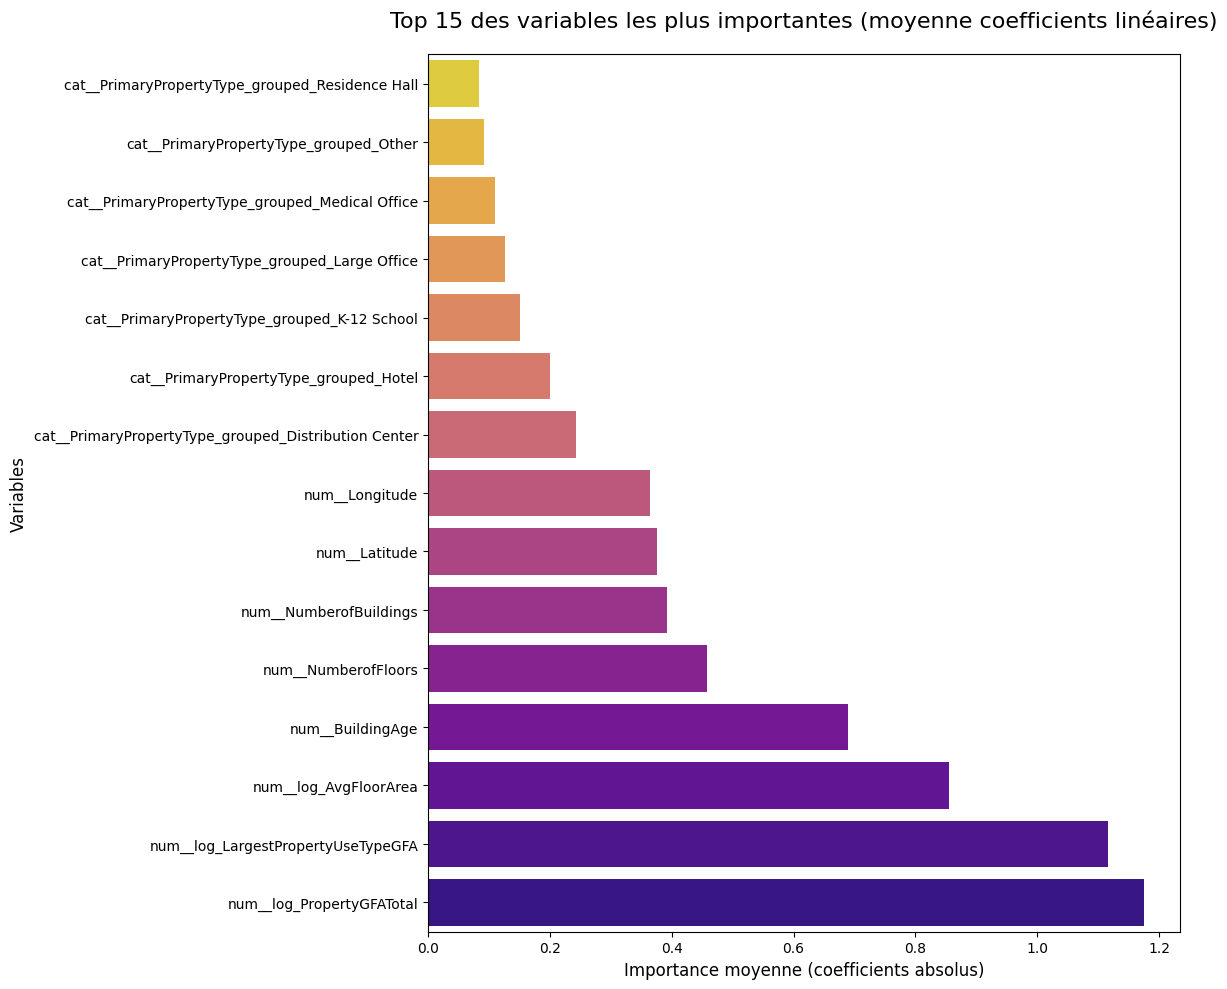


Top 15 des variables les plus importantes :
                                             Feature  Linear_Coefficient_Importance
                           num__log_PropertyGFATotal                       1.175655
                  num__log_LargestPropertyUseTypeGFA                       1.117004
                               num__log_AvgFloorArea                       0.855085
                                    num__BuildingAge                       0.688607
                                 num__NumberofFloors                       0.457517
                              num__NumberofBuildings                       0.391886
                                       num__Latitude                       0.375091
                                      num__Longitude                       0.363936
cat__PrimaryPropertyType_grouped_Distribution Center                       0.243107
              cat__PrimaryPropertyType_grouped_Hotel                       0.200285
        cat__PrimaryPropertyTyp

In [12]:
print("1. ANALYSE DES COEFFICIENTS - MODÈLES LINÉAIRES DU STACKING")
print("-" * 60)

# Récupérer le préprocesseur
preproc_stack = stacking_refined.named_steps['prep']
feature_names = preproc_stack.get_feature_names_out()

# Transformer les données
X_train_transformed = preproc_stack.transform(X_train)
X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index
)

# Analyser chaque composant linéaire
models_analysis = {}

for name, model in [('Ridge', best_fine_tuned_models['ridge']),
                    ('Lasso', best_fine_tuned_models['lasso']),
                    ('ElasticNet', best_fine_tuned_models['elasticnet'])]:

    model.fit(X_train_transformed, y_train)
    coefs = model.coef_

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coefficient': np.abs(coefs)
    }).sort_values('abs_coefficient', ascending=False)

    models_analysis[name] = importance_df

   
# Importance combinée : moyenne des coefficients absolus
print("\n2. IMPORTANCE MOYENNE - MODÈLES LINÉAIRES")
print("-" * 40)

combined_importance = pd.DataFrame({'Feature': feature_names})
for name in ['Ridge', 'Lasso', 'ElasticNet']:
    combined_importance[f'{name}_abs'] = models_analysis[name]['abs_coefficient'].values

combined_importance['Linear_Coefficient_Importance'] = combined_importance[
    ['Ridge_abs', 'Lasso_abs', 'ElasticNet_abs']
].mean(axis=1)

# Tri décroissant
combined_importance = combined_importance.sort_values(
    'Linear_Coefficient_Importance', ascending=False
)

# Top 15 pour visualisation
top_15_features = combined_importance.head(15)

# Visualisation seaborn
plt.figure(figsize=(12, 10))
sns.barplot(
    data=top_15_features,
    x='Linear_Coefficient_Importance',
    y='Feature',
    palette='plasma',
    orient='h'
)
plt.title('Top 15 des variables les plus importantes (moyenne coefficients linéaires)', fontsize=16, pad=20)
plt.xlabel('Importance moyenne (coefficients absolus)', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# Affichage des valeurs numériques
print("\nTop 15 des variables les plus importantes :")
print(top_15_features[['Feature', 'Linear_Coefficient_Importance']].to_string(index=False))


Les variables les plus influentes dans la prédiction de la consommation d’énergie sont liées à la surface (log_PropertyGFA, log_LargestPropertyUseTypeGFA) et aux caractéristiques physiques des bâtiments comme l’âge, le nombre d’étages ou le nombre de bâtiments.  
Des variables catégorielles issues du type d’usage principal du bâtiment (par exemple Hotel, Distribution Center, K-12 School) contribuent aussi significativement aux prédictions.  
Comme pour les émissions, l’importance des variables a été déterminée via la moyenne des coefficients absolus des modèles Ridge, Lasso et ElasticNet, offrant une évaluation stable et interprétable de leur rôle dans le modèle

COMPARAISON AVEC LES MÉTHODES NATIVES

 LASSO
---------------------------------------------


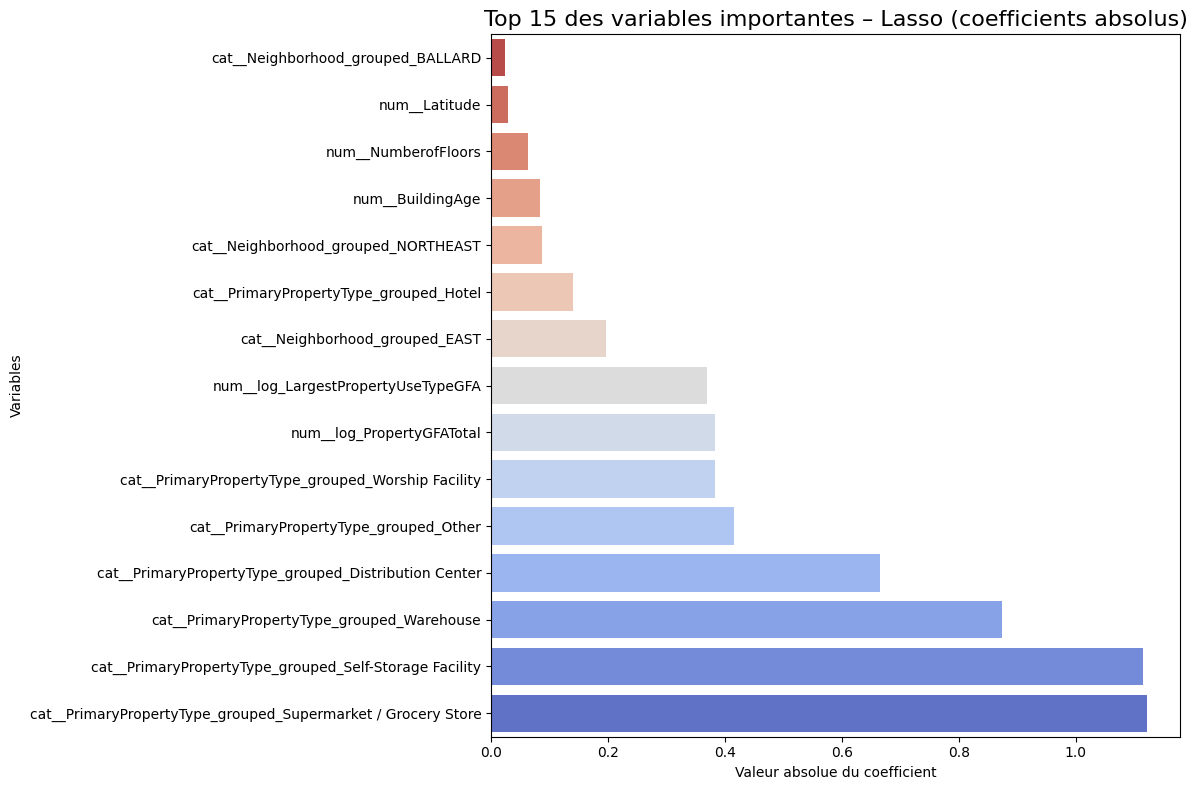

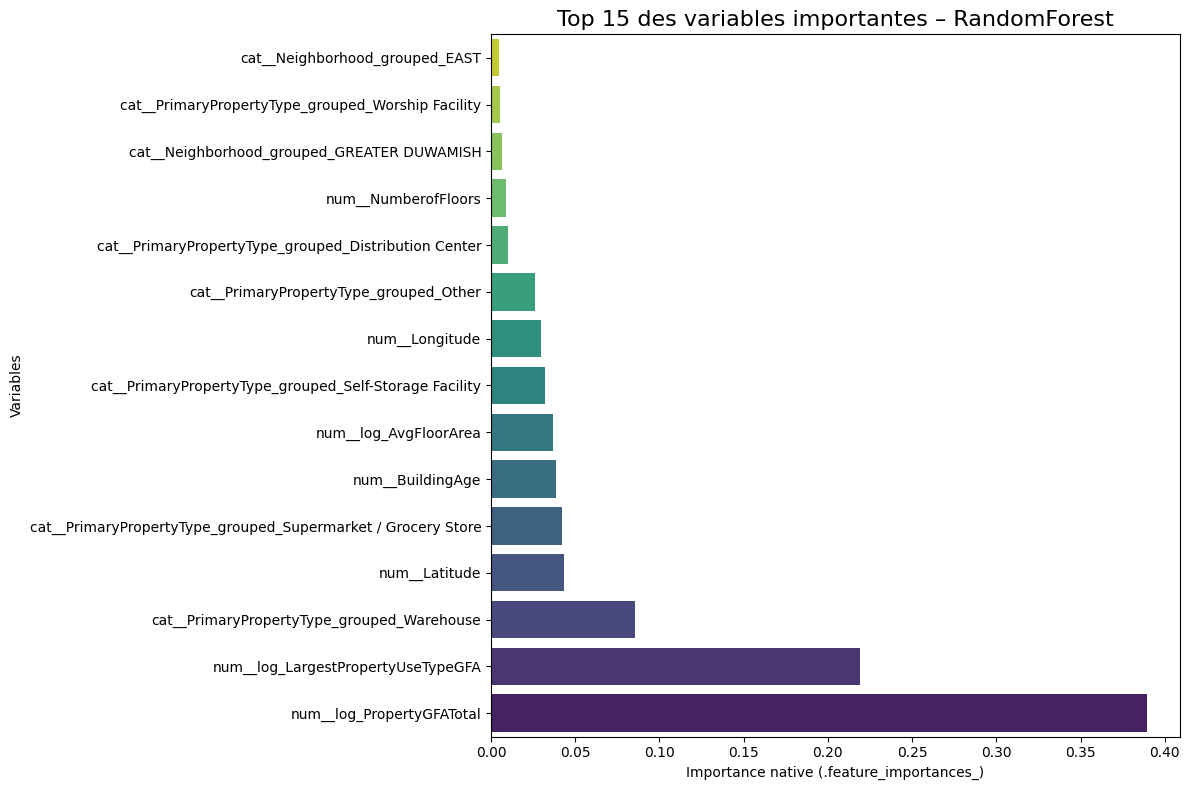

In [13]:
# Comparer avec les méthodes natives (linéaire versus arbre)
print("COMPARAISON AVEC LES MÉTHODES NATIVES")
print("=" * 40)

# 1. Lasso - Coefficients
print("\n LASSO")
print("-" * 45)

# Récupérer le modèle Ridge optimisé
lasso_model = best_fine_tuned_models['lasso']

# L'entraîner sur les données transformées pour avoir les coefficients
X_train_transformed = preproc.fit_transform(X_train)
lasso_model.fit(X_train_transformed, y_train)

# Récupérer les noms des features après transformation
feature_names = preproc.get_feature_names_out()

# Créer le DataFrame d'importance Ridge
lasso_importances = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lasso_model.coef_,
    'abs_coefficient': np.abs(lasso_model.coef_)
}).sort_values('abs_coefficient', ascending=False)


# Créer un RandomForest avec les mêmes paramètres optimisés

rf_model = RandomForestRegressor(
    n_estimators=300, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)

# L'entraînement
rf_model.fit(X_train_transformed, y_train)

# Récupérer l'importance native
rf_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

#  VISUALISATION SEABORN – Lasso
plt.figure(figsize=(12, 8))
sns.barplot(
    data=lasso_importances.head(15),
    x='abs_coefficient',
    y='feature',
    palette='coolwarm',
    orient='h'
)
plt.title('Top 15 des variables importantes – Lasso (coefficients absolus)', fontsize=16)
plt.xlabel('Valeur absolue du coefficient')
plt.ylabel('Variables')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# VISUALISATION SEABORN – RandomForest
plt.figure(figsize=(12, 8))
sns.barplot(
    data=rf_importance.head(15),
    x='importance',
    y='feature',
    palette='viridis',
    orient='h'
)
plt.title('Top 15 des variables importantes – RandomForest', fontsize=16)
plt.xlabel('Importance native (.feature_importances_)')
plt.ylabel('Variables')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()



Analyse des variables influentes – Modèles Lasso & RandomForest sur la consommation énergétiques des bâtiments :

Une double analyse a été menée pour interpréter les facteurs influençant la consommation énergétique :

- **Lasso** (méta-modèle dans le Stacking, a été retenu comme estimateur final, selon son bon score R²)
- **RandomForest** (arbre de décision non linéaire)

Variables les plus influentes

- **Variables numériques (log-transformées)** :
  - `num__log_PropertyGFATotal` (surface totale du bâtiment)
  - `num__log_LargestPropertyUseTypeGFA` (surface de l’usage principal)
  - Ces deux variables apparaissent **tout en haut** du classement dans les deux modèles.
  - Cela est **cohérent avec le domaine** : plus un bâtiment est grand, plus il consomme d’énergie.

- **Variables catégorielles encodées** :
  - Le type de bâtiment (`PrimaryPropertyType_grouped`) joue également un rôle clé.
  - Les catégories les plus importantes incluent :
    - `Supermarket / Grocery Store`
    - `Warehouse`
    - `Self-Storage Facility`
    - `Distribution Center`
  - Ces résultats sont également logiques : ces usages impliquent des niveaux de consommation très différents (ex. : réfrigération, entreposage…).

Interprétation croisée

- Le **Lasso** accorde plus d’importance aux **catégories de bâtiments**, en raison de sa régularisation L1 (sélection stricte).
- Le **RandomForest**, quant à lui, valorise davantage les **variables continues**, notamment les surfaces.

Implications

- Les résultats renforcent l’intérêt du **feature engineering sur les surfaces log-transformées**.
- Les catégories d’usage apparaissant fréquemment comme importantes donc il faut une analyse SHAP pour explorer plus finement leur impact sur la prédiction 





In [14]:
print(X_test['PrimaryPropertyType_grouped'].unique())

['Warehouse' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Residence Hall' 'Large Office' 'Retail Store' 'Other' 'Hotel'
 'Worship Facility' 'Medical Office' 'University' 'Distribution Center'
 'Supermarket / Grocery Store' 'K-12 School']


In [ ]:
# Dictionnaire pour stocker les index des bâtiments à analyser
batiments_a_analyser = {}

# --- Sélection par Type de Bâtiment (consommateurs d'énergie) - cas représentatifs---
colonne_type = 'PrimaryPropertyType_grouped' 
types_a_chercher = ['Warehouse', 'Supermarket / Grocery Store', 'Self-Storage Facility']
for type_batiment in types_a_chercher:
    selection = X_test[X_test[colonne_type] == type_batiment]
    if not selection.empty:
        batiments_a_analyser[type_batiment] = selection.index[0]

# --- Sélection par Taille ---
colonne_surface = 'log_PropertyGFATotal' 
batiments_a_analyser['Le plus grand'] = X_test[colonne_surface].idxmax()
batiments_a_analyser['Le plus petit'] = X_test[colonne_surface].idxmin()

print("Bâtiments sélectionnés pour l'analyse locale :")
print(batiments_a_analyser)

Bâtiments sélectionnés pour l'analyse locale :
{'Warehouse': np.int64(502), 'Supermarket / Grocery Store': np.int64(627), 'Self-Storage Facility': np.int64(529), 'Le plus grand': np.int64(48), 'Le plus petit': np.int64(663)}



Préparation des données de test pour l'analyse locale...
Calcul des valeurs SHAP pour les bâtiments sélectionnés...
-> Données prêtes pour l'analyse locale.

ANALYSE LOCALE - SHAP POUR BÂTIMENTS SPÉCIFIQUES

--- Analyse pour le cas : 'Warehouse' (Index du bâtiment : 502) ---
Caractéristiques principales :
  - Surface totale : 24618 sqft
  - Âge : 84 ans
  - Type : Warehouse
Top 10 features locales (SHAP):
   1. cat__PrimaryPropertyType_grouped_Warehou ↘ -0.5419
   2. num__log_PropertyGFATotal                ↘ -0.4452
   3. num__log_LargestPropertyUseTypeGFA       ↘ -0.3772
   4. cat__PrimaryPropertyType_grouped_Other   ↘ -0.0706
   5. cat__PrimaryPropertyType_grouped_Superma ↘ -0.0396
   6. num__Latitude                            ↗ +0.0295
   7. num__BuildingAge                         ↗ +0.0247
   8. cat__PrimaryPropertyType_grouped_Worship ↗ +0.0143
   9. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0138
  10. cat__Neighborhood_grouped_GREATER DUWAMI ↘ -0.0133

Graphique Waterfall

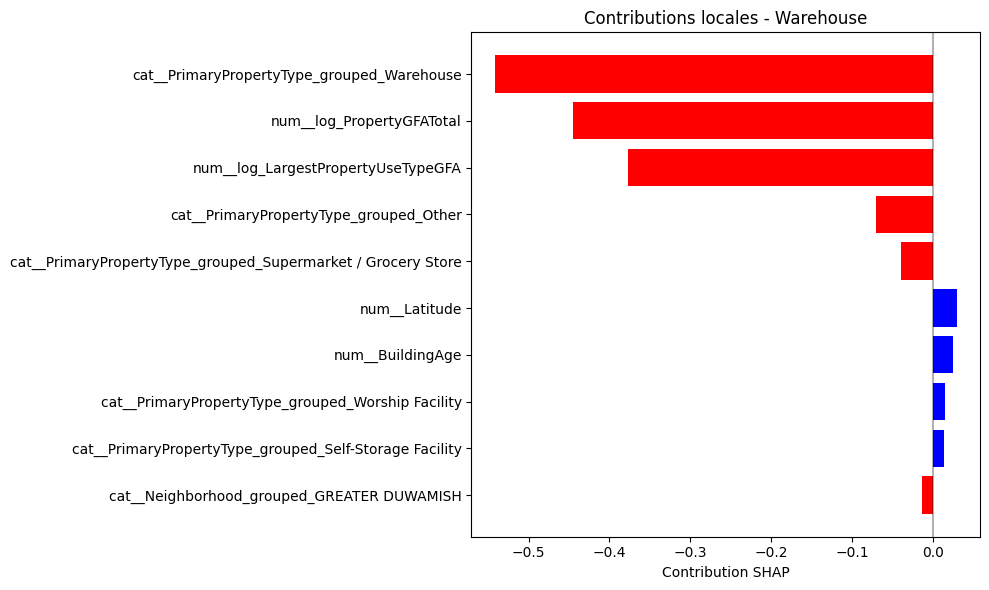

------------------------------------------------------------

--- Analyse pour le cas : 'Supermarket / Grocery Store' (Index du bâtiment : 627) ---
Caractéristiques principales :
  - Surface totale : 45981 sqft
  - Âge : 10 ans
  - Type : Supermarket / Grocery Store
Top 10 features locales (SHAP):
   1. cat__PrimaryPropertyType_grouped_Superma ↗ +0.8736
   2. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.1877
   3. num__BuildingAge                         ↗ +0.0599
   4. num__log_AvgFloorArea                    ↘ -0.0357
   5. cat__PrimaryPropertyType_grouped_Other   ↘ -0.0342
   6. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0307
   7. num__log_LargestPropertyUseTypeGFA       ↗ +0.0247
   8. num__log_PropertyGFATotal                ↘ -0.0140
   9. num__Latitude                            ↗ +0.0121
  10. cat__PrimaryPropertyType_grouped_Distrib ↗ +0.0092

Graphique Waterfall pour 'Supermarket / Grocery Store':


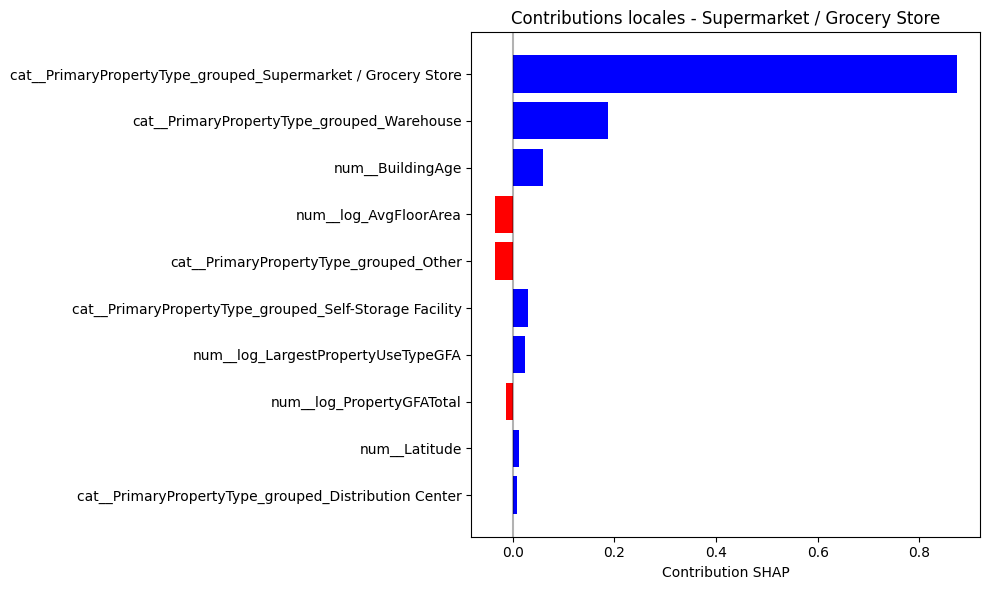

------------------------------------------------------------

--- Analyse pour le cas : 'Self-Storage Facility' (Index du bâtiment : 529) ---
Caractéristiques principales :
  - Surface totale : 28310 sqft
  - Âge : 98 ans
  - Type : Self-Storage Facility
Top 10 features locales (SHAP):
   1. cat__PrimaryPropertyType_grouped_Self-St ↘ -0.9629
   2. num__log_LargestPropertyUseTypeGFA       ↘ -0.3872
   3. num__log_PropertyGFATotal                ↘ -0.2922
   4. cat__PrimaryPropertyType_grouped_Other   ↘ -0.1501
   5. cat__PrimaryPropertyType_grouped_Superma ↘ -0.0656
   6. cat__Neighborhood_grouped_MAGNOLIA / QUE ↘ -0.0605
   7. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.0440
   8. num__BuildingAge                         ↘ -0.0324
   9. num__Longitude                           ↗ +0.0153
  10. cat__PrimaryPropertyType_grouped_Worship ↗ +0.0105

Graphique Waterfall pour 'Self-Storage Facility':


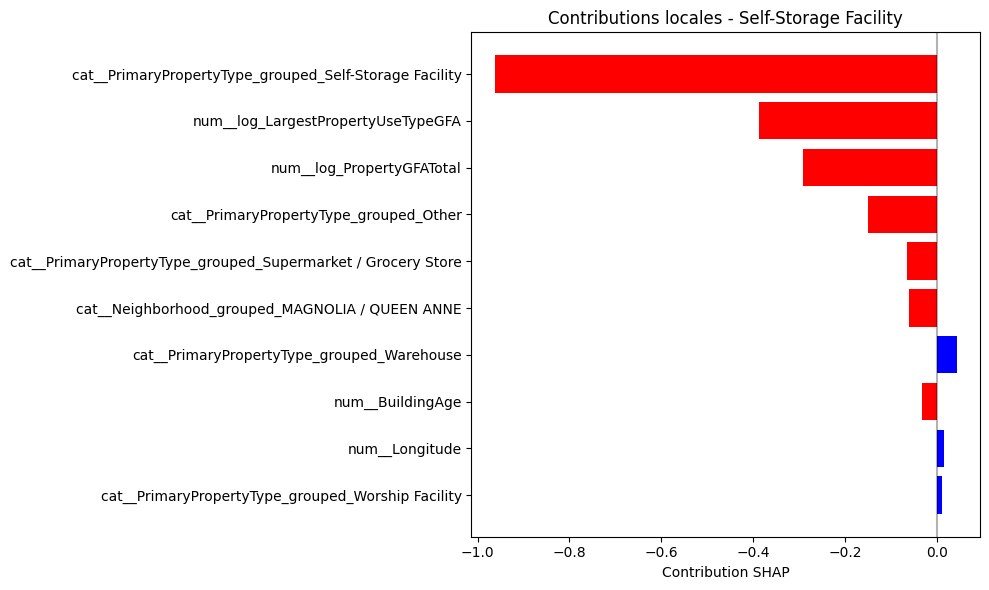

------------------------------------------------------------

--- Analyse pour le cas : 'Le plus grand' (Index du bâtiment : 48) ---
Caractéristiques principales :
  - Surface totale : 879001 sqft
  - Âge : 63 ans
  - Type : Other
Top 10 features locales (SHAP):
   1. num__log_PropertyGFATotal                ↗ +1.7967
   2. num__log_LargestPropertyUseTypeGFA       ↗ +1.1125
   3. cat__PrimaryPropertyType_grouped_Other   ↗ +0.1941
   4. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.1454
   5. num__NumberofFloors                      ↗ +0.0933
   6. num__log_AvgFloorArea                    ↘ -0.0661
   7. num__BuildingAge                         ↘ -0.0376
   8. num__Longitude                           ↗ +0.0220
   9. cat__Neighborhood_grouped_NORTHEAST      ↗ +0.0219
  10. num__Latitude                            ↗ +0.0181

Graphique Waterfall pour 'Le plus grand':


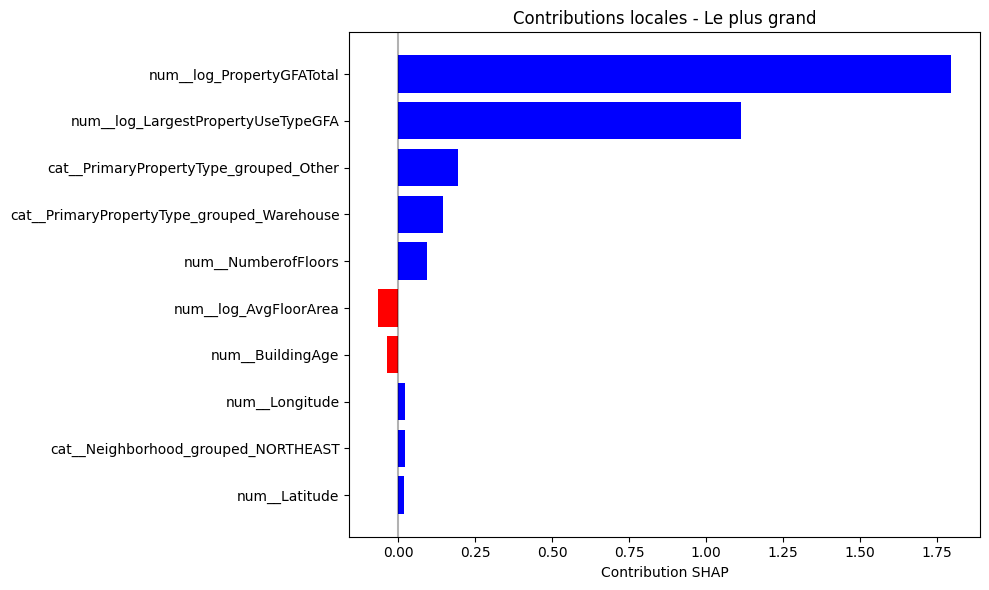

------------------------------------------------------------

--- Analyse pour le cas : 'Le plus petit' (Index du bâtiment : 663) ---
Caractéristiques principales :
  - Surface totale : 11686 sqft
  - Âge : 3 ans
  - Type : Other
Top 10 features locales (SHAP):
   1. num__log_PropertyGFATotal                ↘ -0.9852
   2. num__log_LargestPropertyUseTypeGFA       ↘ -0.3879
   3. cat__PrimaryPropertyType_grouped_Warehou ↗ +0.1078
   4. cat__PrimaryPropertyType_grouped_Other   ↗ +0.0882
   5. num__BuildingAge                         ↗ +0.0714
   6. num__Longitude                           ↘ -0.0628
   7. cat__Neighborhood_grouped_Other          ↘ -0.0459
   8. cat__PrimaryPropertyType_grouped_Superma ↘ -0.0410
   9. cat__PrimaryPropertyType_grouped_Self-St ↗ +0.0144
  10. cat__PrimaryPropertyType_grouped_Worship ↗ +0.0134

Graphique Waterfall pour 'Le plus petit':


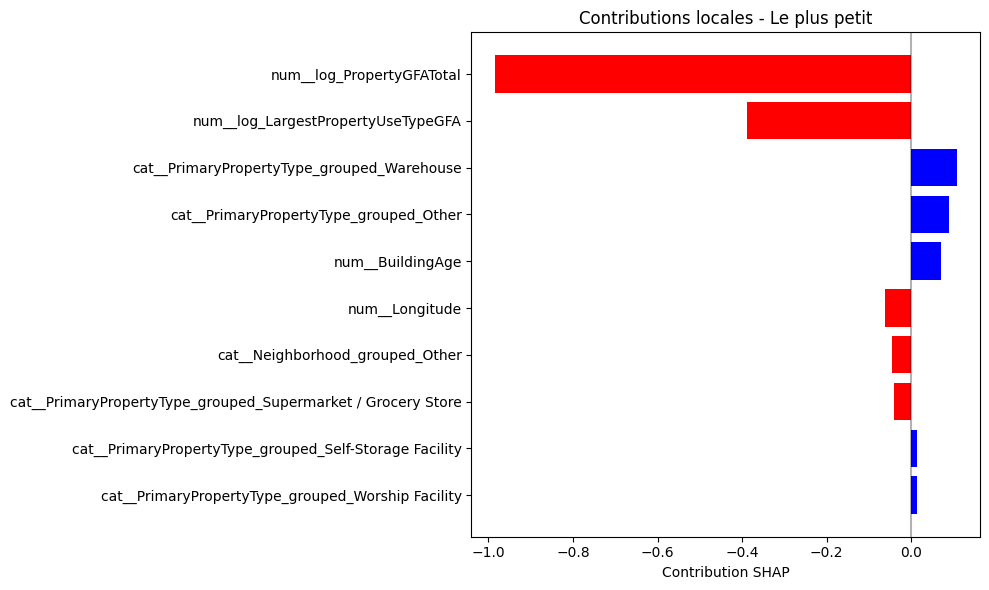

------------------------------------------------------------

ANALYSE LOCALE TERMINÉE


In [16]:
# PRÉPARATION POUR L'ANALYSE LOCALE SUR LE JEU DE TEST
print("\nPréparation des données de test pour l'analyse locale...")

# 1. Transformer les données de test avec le même préprocesseur
X_test_transformed = preproc.transform(X_test)

# 2. Créer le DataFrame transformé pour le jeu de test
X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns=feature_names,
    index=X_test.index
)

# On doit créer un explainer SHAP pour notre RandomForest

explainer = shap.TreeExplainer(rf_model)

# Calculer les valeurs SHAP pour les bâtiments sélectionnés uniquement

selected_indices = list(batiments_a_analyser.values())
X_selected = X_test_transformed_df.loc[selected_indices]

print("Calcul des valeurs SHAP pour les bâtiments sélectionnés...")
shap_values_selected = explainer.shap_values(X_selected)

print("-> Données prêtes pour l'analyse locale.")

# ANALYSE LOCALE POUR CHAQUE BÂTIMENT
print("\n" + "="*60)
print("ANALYSE LOCALE - SHAP POUR BÂTIMENTS SPÉCIFIQUES")
print("="*60)

for i, (nom_cas, idx) in enumerate(batiments_a_analyser.items()):
    
    print(f"\n--- Analyse pour le cas : '{nom_cas}' (Index du bâtiment : {idx}) ---")
    
    # Informations sur le bâtiment
    building_data = X_test.loc[idx]
    print(f"Caractéristiques principales :")
    print(f"  - Surface totale : {np.exp(building_data['log_PropertyGFATotal']):.0f} sqft")
    print(f"  - Âge : {building_data['BuildingAge']:.0f} ans")
    print(f"  - Type : {building_data['PrimaryPropertyType_grouped']}")
    
    # Top 10 features locales les plus importantes
    shap_values_building = shap_values_selected[i]
    local_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_values_building,
        'abs_shap': np.abs(shap_values_building)
    }).sort_values('abs_shap', ascending=False)
    
    print(f"Top 10 features locales (SHAP):")
    for j, (_, row) in enumerate(local_importance.head(10).iterrows()):
        direction = "↗" if row['shap_value'] > 0 else "↘"
        print(f"  {j+1:2}. {row['feature'][:40]:<40} {direction} {row['shap_value']:+.4f}")
    
    # Waterfall plot
    # Les valeurs SHAP positives augmentent la prédiction (plus de conso)
    # Les valeurs SHAP négatives réduisent la prédiction (moins de conso)
    print(f"\nGraphique Waterfall pour '{nom_cas}':")
    try:
        shap.waterfall_plot(
            explainer.expected_value, 
            shap_values_building, 
            X_selected.iloc[i],
            max_display=12,
            show=True
        )
    except:
        # Version alternative si waterfall ne fonctionne pas
        plt.figure(figsize=(10, 6))
        top_features = local_importance.head(10)
        colors = ['red' if x < 0 else 'blue' for x in top_features['shap_value']]
        plt.barh(range(len(top_features)), top_features['shap_value'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Contribution SHAP')
        plt.title(f'Contributions locales - {nom_cas}')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print("-" * 60)

print("\nANALYSE LOCALE TERMINÉE")

**Le plus grand** : Très forte augmentation due à la grande surface totale  
**le plus petit** : Forte réduction de la consommation prédite liée à la petite taille  
**Type self-storage** : Consommation fortement réduite (usage peu énergivore)  
**warehouse** : Réduction modérée de la consommation prédite  
**grocery (supermarket)** : Contribution très élevée du type d’usage (supermarché)  

En conclusion, ici aussi les variables de surface sont les plus influentes en positif comme en négatif, ce qui renforce leur importance métier  
le type de bâtiment a aussi un certain poids sur la prédiction (energivores pour un supermarché, peu de consommations pour les box/entrepôts)  
D'autres variables comme l'âge et la surface moyenne par étage peuvent affiner les prédictions localement mais leur influence reste secondaire.
 


9. ANALYSE ET IMPACT DE LA VARIABLE ENERGYSTARScore

In [17]:
 #On part du dataFrame qui contient toutes les features améliorées

df_subset = df_engineered.dropna(subset=['ENERGYSTARScore']).copy()
print(f"Taille du sous-ensemble avec EnergyStarScore : {len(df_subset)} lignes")

# On définit la cible 
target = 'log_SiteEnergyUse_kBtu'
y_subset = df_subset[target]


# Liste des features de base
base_features = [
    'log_PropertyGFATotal', 'log_LargestPropertyUseTypeGFA', 'log_AvgFloorArea',
    'BuildingAge', 'NumberofFloors', 'NumberofBuildings', 'Latitude', 'Longitude'
]
categorical_features = ['PrimaryPropertyType_grouped', 'Neighborhood_grouped']

#Configuration des features
features_sans_score = base_features + categorical_features
features_avec_score = base_features + ['ENERGYSTARScore'] + categorical_features

X_sans_score = df_subset[features_sans_score]
X_avec_score = df_subset[features_avec_score]

Taille du sous-ensemble avec EnergyStarScore : 669 lignes


In [18]:
# Préprocesseur pour le modèle SANS le score (il est identique à votre 'preprocessor' actuel)
preprocessor_sans_score = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), base_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Préprocesseur pour le modèle AVEC le score
preprocessor_avec_score = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), base_features + ['ENERGYSTARScore']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# On divise les deux jeux de données de la même manière pour une comparaison juste
X_train_sans, X_test_sans, y_train, y_test = train_test_split(X_sans_score, y_subset, test_size=0.2, random_state=42)
X_train_avec, X_test_avec, _, _ = train_test_split(X_avec_score, y_subset, test_size=0.2, random_state=42)

In [19]:
#4. COMPARAISON VALIDE - LES DEUX MODÈLES SUR LE MÊME SOUS-ENSEMBLE
print("\n--- ENTRAÎNEMENT DES MODÈLES STACKING ---")

# Estimateurs de base (mêmes hyperparamètres optimaux)
stack_estimators = [
    ('ridge', Ridge(alpha=1.0)),
    ('lasso', Lasso(alpha=0.01, max_iter=2000)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=2000))
]

# Modèle SANS ENERGYSTARScore
print("Entraînement Stacking SANS ENERGYSTARScore...")
stacking_sans = Pipeline([
    ('prep', preprocessor_sans_score),
    ('model', StackingRegressor(
        estimators=stack_estimators,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    ))
])

stacking_sans.fit(X_train_sans, y_train)
score_sans = stacking_sans.score(X_test_sans, y_test)

# Modèle AVEC ENERGYSTARScore
print("Entraînement Stacking AVEC ENERGYSTARScore...")
stacking_avec = Pipeline([
    ('prep', preprocessor_avec_score),
    ('model', StackingRegressor(
        estimators=stack_estimators,
        final_estimator=LinearRegression(),
        cv=5,
        n_jobs=-1
    ))
])

stacking_avec.fit(X_train_avec, y_train)
score_avec = stacking_avec.score(X_test_avec, y_test)

# 5. RÉSULTATS ET ANALYSE
print("\n" + "="*60)
print("RÉSULTATS DE LA COMPARAISON")
print("="*60)

print(f"R² Stacking SANS ENERGYSTARScore : {score_sans:.4f}")
print(f"R² Stacking AVEC ENERGYSTARScore : {score_avec:.4f}")

# Calcul de l'amélioration
amelioration = score_avec - score_sans
pourcentage_amelioration = (amelioration / abs(score_sans)) * 100

print(f"\nAmélioration apportée par ENERGYSTARScore :")
print(f"Gain en R² : {amelioration:+.4f}")
print(f"Amélioration relative : {pourcentage_amelioration:+.2f}%")

# Interprétation
if amelioration > 0.01:
    print("✓ ENERGYSTARScore apporte une amélioration significative")
elif amelioration > 0:
    print("→ ENERGYSTARScore apporte une amélioration marginale")
elif amelioration > -0.01:
    print("→ ENERGYSTARScore n'apporte pas d'amélioration notable")
else:
    print("✗ ENERGYSTARScore dégrade la performance")

# 6. ANALYSE COMPLÉMENTAIRE - Cross-validation
print("\n--- VALIDATION CROISÉE POUR CONFIRMATION ---")

from sklearn.model_selection import cross_val_score

# CV pour les deux modèles
cv_scores_sans = cross_val_score(stacking_sans, X_train_sans, y_train, cv=5, scoring='r2')
cv_scores_avec = cross_val_score(stacking_avec, X_train_avec, y_train, cv=5, scoring='r2')

print(f"CV R² SANS ENERGYSTARScore : {cv_scores_sans.mean():.4f} ± {cv_scores_sans.std():.4f}")
print(f"CV R² AVEC ENERGYSTARScore : {cv_scores_avec.mean():.4f} ± {cv_scores_avec.std():.4f}")

# 7. PRÉDICTIONS POUR QUELQUES EXEMPLES
print("\n--- EXEMPLES DE PRÉDICTIONS ---")
sample_indices = X_test_avec.index[:3]

for i, idx in enumerate(sample_indices):
    building_data = df_subset.loc[idx]
    
    pred_sans = stacking_sans.predict(X_test_sans.loc[[idx]])[0]
    pred_avec = stacking_avec.predict(X_test_avec.loc[[idx]])[0]
    actual = y_test.loc[idx]
    energy_score = building_data['ENERGYSTARScore']
    
    print(f"\nBâtiment {i+1} (ENERGYSTARScore: {energy_score:.0f}):")
    print(f"  Réel : {actual:.3f}")
    print(f"  Pred SANS score : {pred_sans:.3f}")
    print(f"  Pred AVEC score : {pred_avec:.3f}")
    print(f"  Amélioration : {abs(pred_avec - actual) - abs(pred_sans - actual):+.3f}")




--- ENTRAÎNEMENT DES MODÈLES STACKING ---
Entraînement Stacking SANS ENERGYSTARScore...
Entraînement Stacking AVEC ENERGYSTARScore...

RÉSULTATS DE LA COMPARAISON
R² Stacking SANS ENERGYSTARScore : 0.6592
R² Stacking AVEC ENERGYSTARScore : 0.7371

Amélioration apportée par ENERGYSTARScore :
Gain en R² : +0.0780
Amélioration relative : +11.83%
✓ ENERGYSTARScore apporte une amélioration significative

--- VALIDATION CROISÉE POUR CONFIRMATION ---
CV R² SANS ENERGYSTARScore : 0.6618 ± 0.0544
CV R² AVEC ENERGYSTARScore : 0.7496 ± 0.0561

--- EXEMPLES DE PRÉDICTIONS ---

Bâtiment 1 (ENERGYSTARScore: 60):
  Réel : 13.510
  Pred SANS score : 12.974
  Pred AVEC score : 12.825
  Amélioration : +0.149

Bâtiment 2 (ENERGYSTARScore: 89):
  Réel : 14.820
  Pred SANS score : 15.042
  Pred AVEC score : 14.750
  Amélioration : -0.154

Bâtiment 3 (ENERGYSTARScore: 44):
  Réel : 14.835
  Pred SANS score : 13.467
  Pred AVEC score : 13.571
  Amélioration : -0.104


EnergyStarScore est conçu pour refléter l'efficacité énergétique globale d’un bâtiment.  

Il est fortement corrélé à la consommation d’énergie dans notre jeu de données.   
On voit la nette progression sur l'entraînement que sur la validation croisée.  

Son ajout dans le modèle de stacking permet de mieux capturer des effets croisés entre les usages, la surface, l’âge du bâtiment et sa performance énergétique globale.  

Conclusion  

L'inclusion de la variable EnergyStarScore dans le modèle de prédiction renforce clairement sa performance. Elle apporte une information pertinente et complémentaire aux autres variables explicatives.  